In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
from numpy.random import default_rng
import cvxpy as cp
import networkx as nx
import mosek
import custom_networks

from solution_files_manager import SolutionFilesManager
from opt_utils import decompose_psd, complex_hyperplane_rounding, fixed_point_iteration
from opf_utils import *

In [2]:
import os
folder = os.path.abspath(os.getcwd())

## Data processing

In [3]:
case = "case14"
net = custom_networks.get_case(case)
n = len(net.bus)

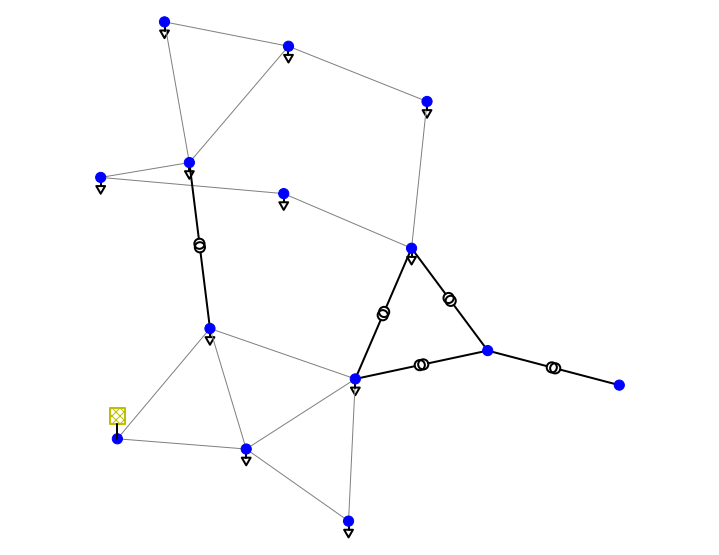

<AxesSubplot:>

In [4]:
simple_plot(net, plot_loads=True, plot_sgens=True)

#### Generators

In [5]:
gen_df_list = []
gen_class_list = ["ext_grid", "gen", "sgen"]  # the 3 types of generators
data_col_list = ["bus", "max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]

for gen_class in gen_class_list:
    if not net[gen_class].empty:
        # get a table of cost coefficients only for the current type of generators
        gen_class_poly_cost = net.poly_cost.loc[net.poly_cost.et == gen_class].set_index("element")
        # get a table of cost coefficients and power bounds only for the current type of generators
        gen_class_df = net[gen_class][data_col_list].join(gen_class_poly_cost)
        gen_df_list.append(gen_class_df)

# combine tables for all types of generators
gen_df = pd.concat(gen_df_list).reset_index()
n_gen = len(gen_df)
gens = gen_df["bus"].to_numpy()

In [6]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,0,332.4,0.0,10.0,0.0,ext_grid,0.0,20.0,0.043029,0.0,0.0,0.0
1,0,1,140.0,0.0,50.0,-40.0,gen,0.0,20.0,0.250000,0.0,0.0,0.0
2,1,2,100.0,0.0,40.0,0.0,gen,0.0,40.0,0.010000,0.0,0.0,0.0
3,2,5,100.0,0.0,24.0,-6.0,gen,0.0,40.0,0.010000,0.0,0.0,0.0
4,3,7,100.0,0.0,24.0,-6.0,gen,0.0,40.0,0.010000,0.0,0.0,0.0


#### Bus loads

In [7]:
load_df = net.bus.join(net.load[["bus", "p_mw", "q_mvar"]].set_index("bus")).fillna(0)[["p_mw", "q_mvar"]]

In [8]:
load_df

,p_mw,q_mvar
0,0.0,0.0
1,21.7,12.7
2,94.2,19.0
3,47.8,-3.9
4,7.6,1.6
5,11.2,7.5
6,0.0,0.0
7,0.0,0.0
8,29.5,16.6
9,9.0,5.8


#### Admittance matrices

In [9]:
# compute line susceptance in p.u.
net.line['s_pu'] = net.line['c_nf_per_km'] * net.line["length_km"] * (2 * np.pi * net.f_hz) * \
    ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2) / net.sn_mva / net.line['parallel'] / 1e9

In [10]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

In [11]:
G_val, B_val, Y_val = compute_admittance_mat(net, graph)

## Variables

In [12]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [13]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [14]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)
Y = cp.Parameter((n,n), complex=True, value=Y_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
# TODO: check whether these are for net injections (supply - demand) or for generated power (supply)
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [15]:
# vectors of cost coefficients: c_[p or q]_[power]
# costs are only on generators

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

## Constraints

In [16]:
# SOCP constraint
# constraints = [ cp.quad_over_lin(cp.norm(X[i][j]), cp.real(X[i][i])) <= cp.real(X[j][j]) for i,j in graph.edges]

### SDP (non-QCQP)

In [17]:
constraints = [X >> 0]

for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

In [18]:
p_cost = c_p_2 @ cp.square(p_g) + c_p_1 @ p_g + cp.sum(c_p_0)
q_cost = c_q_2 @ cp.square(q_g) + c_q_1 @ q_g + cp.sum(c_q_0)

In [19]:
# original cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# heuristic penalization
# prob = cp.Problem(cp.Minimize(p_cost + q_cost + 0.5 * cp.sum(q_g)), constraints)
# prob = cp.Problem(cp.Minimize(p_cost + q_cost - cp.real(cp.sum(X))), constraints)

In [20]:
# prob.solve(solver=cp.SCS, verbose=True)  # eps=1e-6
# prob.solve(solver=cp.CVXOPT, verbose=True)
prob.solve(solver=cp.MOSEK, mosek_params={mosek.iparam.intpnt_solve_form : mosek.solveform.dual}, verbose=False)

print("The optimal value is", prob.value)

The optimal value is 8079.950249969521


In [21]:
np.linalg.eigvalsh(X.value)

array([-3.51293794e-09, -3.29207084e-09, -3.19338495e-09, -3.15563612e-09,
       -2.94012688e-09, -2.62266383e-09, -2.18628083e-09, -1.54775924e-09,
       -1.36428310e-09,  4.72357684e-10,  2.03694901e-06,  4.50949159e-06,
        2.48306274e-03,  1.47602256e+01])

In [22]:
# # print original cost (if using penalization)
# print(p_cost.value + q_cost.value)

### SDP (QCQP)

In [23]:
Phis = []
Psis = []
for i in range(n):
    J_i = np.zeros((n,n))
    J_i[i][i] = 1
    Y_i = J_i @ Y
    Phi_i = 1 / 2 * (Y_i.H + Y_i)
    Phis.append(Phi_i)
    Psi_i = 1 / 2j * (Y_i.H - Y_i)
    Psis.append(Psi_i)

In [24]:
# sparsity_graph_real = nx.Graph()
# graph_nodes_list = sorted(graph.nodes())
# sparsity_graph_real.add_nodes_from(graph_nodes_list)
# sparsity_graph_real.add_edges_from(graph.edges())
# sparsity_graph_imag = sparsity_graph_real.copy()
# sparsity_graph_imag = nx.relabel_nodes(sparsity_graph_imag, lambda a : a + n)
# sparsity_graph = nx.compose(sparsity_graph_real, sparsity_graph_imag)
# for i in graph_nodes_list:
#     for j in sparsity_graph_real.neighbors(i):
#         sparsity_graph.add_edge(i, n + j)
#         sparsity_graph.add_edge(n + i, j)

In [114]:
sparsity_graph = nx.Graph()
graph_nodes_list = sorted(graph.nodes())
sparsity_graph.add_nodes_from(graph_nodes_list)
sparsity_graph.add_edges_from(graph.edges())

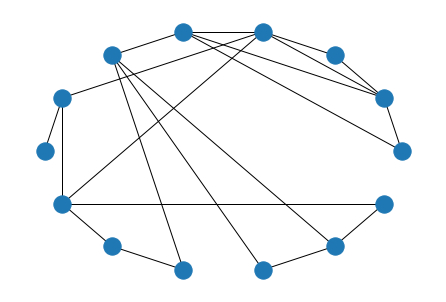

In [115]:
nx.draw(sparsity_graph, nx.circular_layout(sparsity_graph))

In [116]:
treewidth_algorithm_idx = 1
treewidth_algorithms_list = [nx.algorithms.approximation.treewidth_min_degree, nx.algorithms.approximation.treewidth_min_fill_in] # nx.junction_tree
treewidth, tree_decomp = treewidth_algorithms_list[treewidth_algorithm_idx](sparsity_graph)

In [117]:
tree_decomp.nodes

NodeView((frozenset({8, 12, 13}), frozenset({8, 12, 5}), frozenset({8, 10, 5}), frozenset({8, 9, 10}), frozenset({8, 4, 5}), frozenset({8, 3, 4}), frozenset({11, 12, 5}), frozenset({8, 3, 6}), frozenset({1, 3, 4}), frozenset({1, 2, 3}), frozenset({0, 1, 4}), frozenset({6, 7})))

### Construct enriched supergraph

In [118]:
# tree_decomp = nx.relabel_nodes(tree_decomp, lambda bag : bag.union(frozenset(range(tree_decomp.number_of_nodes(), tree_decomp.number_of_nodes() + treewidth + 1 - len(bag)))) if len(bag) < treewidth + 1 else bag)

In [125]:
G_bar = sparsity_graph.copy()

In [119]:
next_idx = G_bar.number_of_nodes()
T_bar = tree_decomp.copy()

for bag in tree_decomp.nodes:
    if len(bag) < treewidth + 1:
        new_bag = bag.union(frozenset(range(next_idx, next_idx + treewidth + 1 - len(bag))))
        T_bar = nx.relabel_nodes(T_bar, {bag : new_bag})
        next_idx += treewidth + 1 - len(bag)

sparsity_graph.add_nodes_from(range(sparsity_graph.number_of_nodes(), next_idx))

In [126]:
T_tilde = T_bar.copy()

In [127]:
while T_tilde.number_of_nodes() > 1:
    for bag in T_tilde.nodes:
        if T_tilde.degree(bag) == 1:
            parent = list(T_tilde.neighbors(bag))[0]
            Os = sorted(list(bag.difference(parent)))
            Ws = sorted(list(parent.difference(bag)))
            G_bar.add_edges_from([(Os[i], Ws[i]) for i in range(len(Os))])
            T_tilde.remove_node(bag)
            break

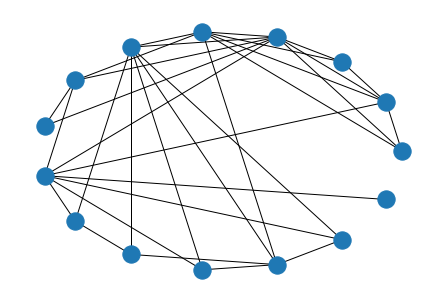

In [128]:
nx.draw(G_bar, nx.circular_layout(G_bar))

In [75]:
# edge_elimination_list = list(sparsity_graph.edges)

In [76]:
# sparsity_graph.remove_edges_from(edge_elimination_list)

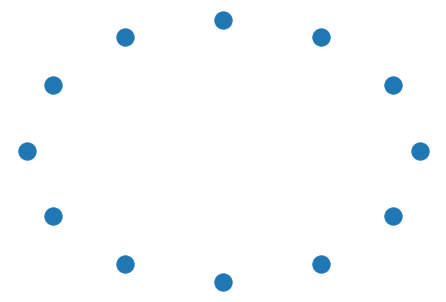

In [77]:
# nx.draw(sparsity_graph, nx.circular_layout(sparsity_graph))

In [78]:
# for e in edge_elimination_list:
#     sparsity_graph.add_node((e,1))
#     sparsity_graph.add_node((e,2))
# sparsity_graph.add_node("one")
# for e in edge_elimination_list:
#     sparsity_graph.add_edge((e,1), "one")
#     sparsity_graph.add_edge((e,2), "one")
#     sparsity_graph.add_edge(e[0], "one")
#     sparsity_graph.add_edge(e[1], "one")

In [80]:
# nx.set_edge_attributes(sparsity_graph, 0, "weight")

In [32]:
# constraints = []

In [ ]:
# n_sparse = sparsity_graph.number_of_nodes()
# m_eliminated = len(edge_elimination_list)
# sparsity_graph_edges = list(sparsity_graph.edges)
#
# for i in range(n):
#     graph_g_i = sparsity_graph.copy()
#     graph_g_i.add_edge(i, i, weight=G_val[i][i])
#     graph_g_i.add_edge(n + i, n + i, weight=G_val[i][i])
#
#     # graph_b_i
#
#     for j in graph.neighbors(i):
#         if (i,j) not in graph_g_i.edges:
#             # replace variables in the current constraints
#             graph_g_i.edges[(((i, j), 1), ((i, j), 1))]["weight"] = G_val[i][j]
#             graph_g_i.edges[(((i, j), 2), ((i, j), 2))]["weight"] = -G_val[i][j]
#             graph_g_i.edges[(((n + i, n + j), 1), ((n + i, n + j), 1))]["weight"] = G_val[i][j]
#             graph_g_i.edges[(((n + i, n + j), 2), ((n + i, n + j), 2))]["weight"] = -G_val[i][j]
#             graph_g_i.edges[(((i, n + j), 1), ((i, n + j), 1))]["weight"] = -B_val[i][j]
#             graph_g_i.edges[(((i, n + j), 2), ((i, n + j), 2))]["weight"] = B_val[i][j]
#             graph_g_i.edges[(((n + i, j), 1), ((n + i, j), 1))]["weight"] = B_val[i][j]
#             graph_g_i.edges[(((n + i, j), 2), ((n + i, j), 2))]["weight"] = -B_val[i][j]
#
#             # graph_b_i
#
#             # impose linear constraints on the new variables
#             linear_constraint_mat = np.zeros(n_sparse)
#             # TODO
#
#
#         else:
#             # don't replace variables
#             graph_g_i.edges[(i, j)]["weight"] = G_val[i][j]
#             graph_g_i.edges[(n + i, n + j)]["weight"] = G_val[i][j]
#             graph_g_i.edges[(i, n + j)]["weight"] = -B_val[i][j]
#             graph_g_i.edges[(n + i, j)]["weight"] = B_val[i][j]

In [82]:
constraints = [X >> 0]

for i in range(n):
    # TODO: multiple generators at one bus
    if i in gens:
        i_gen_idx = list(gens).index(i)
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] <= p_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] >= p_min[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] <= q_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] >= q_min[i_gen_idx] ]
    else:
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) == -p_d[i] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) == -q_d[i] ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [83]:
p_cost = cp.sum([ c_p_2[i] * cp.square((cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]])) + c_p_1[i] * (cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_p_0)
q_cost = cp.sum([ c_q_2[i] * cp.square((cp.real(cp.trace(Psis[gens[i]] @ X)) + p_d[gens[i]])) + c_q_1[i] * (cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_q_0)

In [84]:
loss_cost = cp.sum([ cp.sum([ G[i][j] * cp.real(X[i][i] + X[j][j] - X[i][j] - X[j][i]) for j in range(i)]) for i in range(n)])

In [21]:
# original cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# line loss
# prob = cp.Problem(cp.Minimize(loss_cost), constraints)

In [22]:
# prob.solve(solver=cp.SCS, verbose=True)  # eps=1e-6
# prob.solve(solver=cp.CVXOPT, verbose=True)
prob.solve(solver=cp.MOSEK, mosek_params={mosek.iparam.intpnt_solve_form : mosek.solveform.dual}, verbose=True)

print("The optimal value is", prob.value)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jun 20 10:20:03 PM: Your problem has 1541 variables, 85 constraints, and 3298 parameters.
(CVXPY) Jun 20 10:20:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 20 10:20:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 20 10:20:03 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 20 10:20:03 PM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Jun 20 10:20:03 PM: Applying reduction Complex2Real
(CVXPY) Jun 20 10:20:03 PM: Applying reduc

In [90]:
# print(p_g.value)
# print(q_g.value)

### Fixed point iterations

In [103]:
X_ac = cp.Variable((n,n), hermitian=True)

In [104]:
prob_ac = cp.Problem(cp.Maximize(cp.log_det(X_ac) \
                              + cp.sum([ cp.log(p_max[i] - cp.real(cp.trace(Phis[i] @ X_ac)) - p_d[gens[i]]) + cp.log(cp.real(cp.trace(Phis[i] @ X_ac)) + p_d[gens[i]] - p_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(q_max[i] - cp.real(cp.trace(Psis[i] @ X_ac)) - q_d[gens[i]]) + cp.log(cp.real(cp.trace(Psis[i] @ X_ac)) + q_d[gens[i]] - q_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(V_max_sq[i] - cp.real(X_ac[i][i])) + cp.log(cp.real(X_ac[i][i]) - V_min_sq[i]) for i in range(n) ]) ), constraints)

prob_ac.solve(solver=cp.SCS)

-192.63402081501656

In [108]:
# fixed_point_iteration(prob, X, np.zeros((n,n)), True)
fixed_point_iteration(prob, X, -X_ac.value, True)

Initial objective:  574.5167504598561
Initial rank:  19
Current objective:  894.5288675304578
Current rank:  8
Current objective:  902.7738081470595
Current rank:  20
Current objective:  902.7908719730777
Current rank:  3
Current objective:  902.7916053095965
Current rank:  3
Current objective:  902.7916647735258
Current rank:  3
Current objective:  902.7916726460846
Current rank:  3
Current objective:  902.7916738503202
Current rank:  3
Fixed point objective:  902.7916740402607
Fixed point rank:  3
Fixed point eigenvalues:
[-4.80877204e-12 -4.52151158e-12 -4.44733337e-12 -4.42572063e-12
 -4.24062149e-12 -3.72819808e-12 -3.53221828e-12 -3.47548369e-12
 -3.05532024e-12 -2.43904864e-12 -1.67353198e-12 -1.05269331e-12
 -6.01600829e-13 -2.96283508e-13  2.09379950e-12  3.09620076e-12
  3.60283541e-12  4.02978383e-12  5.30850073e-12  7.87925092e-12
  9.01437708e-12  1.34021271e-11  1.65020463e-11  2.74515393e-11
  8.06285825e-11  1.72448358e-10  4.20399550e-10  1.49224666e-09
  6.86872662e-0

### Hyperplane rounding

In [ ]:
def cost_from_exact_solution(v):
    X_exact = np.outer(v, v.conj())
    p_g, q_g = compute_generation(X_exact, n_gen, p_d_val, q_d_val, G_val, B_val, graph)
    p_cost = np.sum(c_p_2.value @ np.square(p_g) + c_p_1.value @ p_g + np.sum(c_p_0.value))
    q_cost = np.sum(c_q_2.value @ np.square(q_g) + c_q_1.value @ q_g + np.sum(c_q_0.value))
    return p_cost + q_cost

In [ ]:
# note that this usually results in an infeasible point
hyperplane_cost, hyperplane_v = complex_hyperplane_rounding(decompose_psd(X.value), cost_from_exact_solution, net.bus["min_vm_pu"].to_numpy(), net.bus["max_vm_pu"].to_numpy())
print(hyperplane_cost)

In [ ]:
check_power_feasibility(hyperplane_v, p_min.value, p_max.value, q_min.value, q_max.value, n_gen, p_d_val, q_d_val, G_val, B_val, graph)

In [ ]:
# sfm = SolutionFilesManager(folder, case, "sdp")
# sfm.save_solution(prob.value, X, p_g, q_g)

### Verify correctness of constraints

In [5]:
# load pandapower solution
sfm = SolutionFilesManager(folder, case, "orig")
_, V_orig, p_g_orig, q_g_orig = sfm.load_solution()

In [11]:
X_orig = np.outer(V_orig, V_orig.conj())

In [12]:
verify_feasibility(X_orig, p_g_orig, q_g_orig, p_d_val, q_d_val, gen_df, G_val, B_val, graph)

NameError: name 'p_d_val' is not defined